In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import os
import glob
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.lines import Line2D
import ipywidgets
from ipywidgets import fixed
from termcolor import colored
from scipy import interpolate
from mpl_chord_diagram import chord_diagram
from calendar import isleap

import sys
import time
import random
import os
import math
import pickle
from matplotlib import cm

import xarray as xr
import numcodecs
import zarr

from joblib import Parallel, delayed

from pandas.plotting import register_matplotlib_converters
from matplotlib import rcParams
rcParams["font.size"]=14
plt.rcParams.update({'figure.max_open_warning': 0})
register_matplotlib_converters()

In [2]:
## Local function
sys.path.insert(1, './Functions')

from PN1_5_RoutineSource import *
from ProcessNetwork1_5MainRoutine_sourceCode import *
from plottingUtilities_Widget import *

In [3]:
# local file paths
np.random.seed(50)
pathData = (r"./preppedData/")
pathResult = (r"./Result/")

In [4]:
'''Load Uncalibrated Data'''
TableHeader = ['observed_Q','basin_ppt','basin_tmin','basin_tmax','model_Q','basin_soil_moist','basin_snowmelt','basin_actet','basin_potet']

UnCalibMat_clm = np.loadtxt(pathData + 'clmData.txt', delimiter='\t', skiprows = 1)
UnCalibMat_hillslope = np.loadtxt(pathData + 'HillslopeData.txt', delimiter='\t', skiprows = 1)
UnCalibMat_spruce = np.loadtxt(pathData + 'SPRUCEData.txt', delimiter='\t', skiprows = 1)

In [5]:
startD = '2011-01-01'
endD = '2016-12-31'
dateTimeD = pd.date_range(start=startD, end=endD)
#Remove Leap year days
dateTimeD = pd.DatetimeIndex(data=(t for t in dateTimeD if not (isleap(t.year) & (t.month == 2) & (t.day == 29))))
dateTimeD

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', length=2190, freq=None)

In [6]:
PdUnCalib_clm = pd.DataFrame(data=UnCalibMat_clm, columns=TableHeader, index=dateTimeD)
PdUnCalib_hillslope = pd.DataFrame(data=UnCalibMat_hillslope, columns=TableHeader, index=dateTimeD)
PdUnCalib_spruce = pd.DataFrame(data=UnCalibMat_spruce, columns=TableHeader, index=dateTimeD)
PdUnCalib_clm.shape

(2190, 9)

# Exploratory Analysis

In [7]:
# Long term monthly hydroclimatic characteristics  
MonthlyAverage = PdUnCalib_clm.groupby(PdUnCalib_clm.index.month).mean()
A = 344445 # Area in sq ft. (3.2 Ha)
# MonthlyAverage

In [36]:
def plotMonthlyHydroClimate(MonthlyAverage,Area):
    
    ''' Generates a plot of Longterm averaged monthly observed hydrometeorological variables Precipitation,
     Streamflow and Air temperature.
     
     Parammeters
     -------------
     MonthlyAverage - dataframe with containg longterm monthly averages.
     Area - catchment area in square ft.
     
    Returns
    ------------
    A time series plot of Precipitation, Streamflow and Air temperature.
    '''
        
    T = 24*60*60
    ft_to_in = 12
    labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    x = np.arange(len(labels))  # the label locations

    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=[7,5])
    rects1 = ax.bar(x - width/2, MonthlyAverage.observed_Q*(T/Area)*(30*ft_to_in), width, color='r', label='Streamflow')
    rects2 = ax.bar(x + width/2, MonthlyAverage.basin_ppt*30, width, color='k', label='Precipitation')

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Streamflow and Precipitation (in)',fontsize=14)
    ax.set_xlabel('Months', fontsize=14)
    plt.xticks(rotation=90, horizontalalignment="center")
    #ax.set_title('HJ Andrews')
    ax.set_xticks(x)
    ax.set_xticklabels(labels,fontsize=12)


    axes2 = plt.twinx()

    for label in (axes2.get_xticklabels() + axes2.get_yticklabels()):
        label.set_fontsize(12)

    axes2.plot(x,0.5*(MonthlyAverage.basin_tmin + MonthlyAverage.basin_tmax) , marker='o', color='b', label='Air Temperature')
    #axes2.set_ylim(-1, 1)
    axes2.set_ylabel('Air temperature ($^o$F)', color='b',fontsize=14)


    ax.legend(loc='upper left', bbox_to_anchor=(1.15, 1),frameon=False,fontsize=12)
    plt.legend(loc='upper left', bbox_to_anchor=(1.15, 0.87),frameon=False,fontsize=12)

    plt.savefig("./Result/CatchmentCharacteristics.jpg", dpi=300,bbox_inches='tight')

    plt.show()

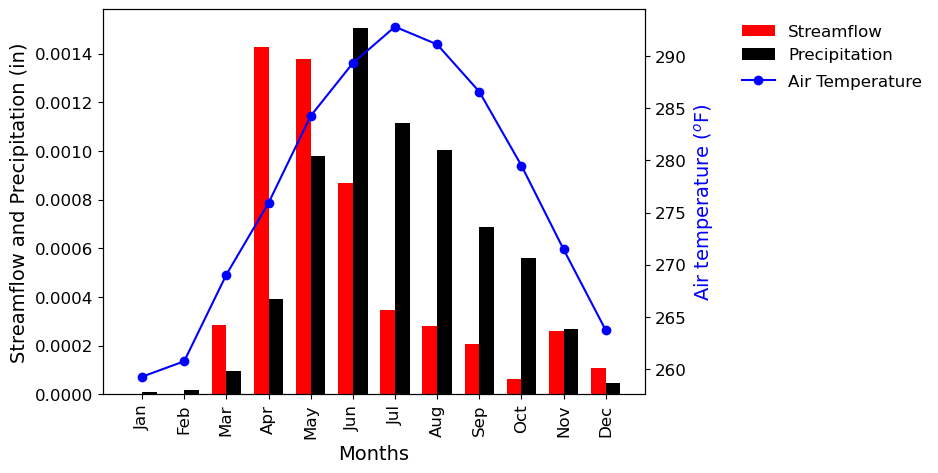

In [37]:
plotMonthlyHydroClimate(MonthlyAverage, A)

In [38]:
# Day of the year averages
DoY_Av_UnCalib = PdUnCalib_clm.groupby([(PdUnCalib_clm.index.month),(PdUnCalib_clm.index.day)]).mean()
DoY_Max_UnCalib = PdUnCalib_clm.groupby([(PdUnCalib_clm.index.month),(PdUnCalib_clm.index.day)]).max()
DoY_Min_UnCalib = PdUnCalib_clm.groupby([(PdUnCalib_clm.index.month),(PdUnCalib_clm.index.day)]).min()

In [126]:
def plotDoYBounds(Df1, Df2, Df3, VarName, ylabel, label1, label2, label3):
    '''
    Returns
    --------
    A filled plot showing max, min and average across the day of a year.
    
    '''
    # Uncalibrated
    plt.figure(figsize=[7,5],dpi=300)
    plt.subplot(2,1,1)
    
    xDim = np.arange(0, 366)

    #Take out min, max, and avg data for each model
    Df1Av = Df1.groupby(Df1.index.dayofyear).mean()
    Df1Min = Df1.groupby(Df1.index.dayofyear).min()
    Df1Max = Df1.groupby(Df1.index.dayofyear).max()

    Df2Av = Df2.groupby(Df2.index.dayofyear).mean()
    Df2Min = Df2.groupby(Df2.index.dayofyear).min()
    Df2Max = Df2.groupby(Df2.index.dayofyear).max()

    Df3Av = Df3.groupby(Df3.index.dayofyear).mean()
    Df3Min = Df3.groupby(Df3.index.dayofyear).min()
    Df3Max = Df3.groupby(Df3.index.dayofyear).max()

    plt.plot(xDim, Df1Av[VarName],'b-', label = label1)
    plt.fill_between(xDim, Df1Min[VarName], Df1Max[VarName], color = 'b', alpha = 0.5)

    plt.plot(xDim, Df2Av[VarName],'r-', label = label2)
    plt.fill_between(xDim, Df2Min[VarName], Df2Max[VarName], color = 'r', alpha = 0.5)

    plt.plot(xDim, Df3Av[VarName],'g-', label = label3)
    plt.fill_between(xDim, Df3Min[VarName], Df3Max[VarName], color = 'g', alpha = 0.5)

    tick_locations = np.arange(0,len(xDim),31)
    labels = np.resize(['Jan','Feb','Mar','Apr', 'May','Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov','Dec'], len(tick_locations))
    plt.xticks(tick_locations, labels,fontsize=10)
    plt.yticks(fontsize=10)
    
    plt.ylabel(ylabel,fontsize=10)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1),frameon=False,fontsize=12)
    
    plt.xlabel('Day of the Year')

    plt.grid(linestyle='-.')

    plt.savefig("modelVar_" + str(VarName) + ".jpg", dpi=300, bbox_inches = 'tight')

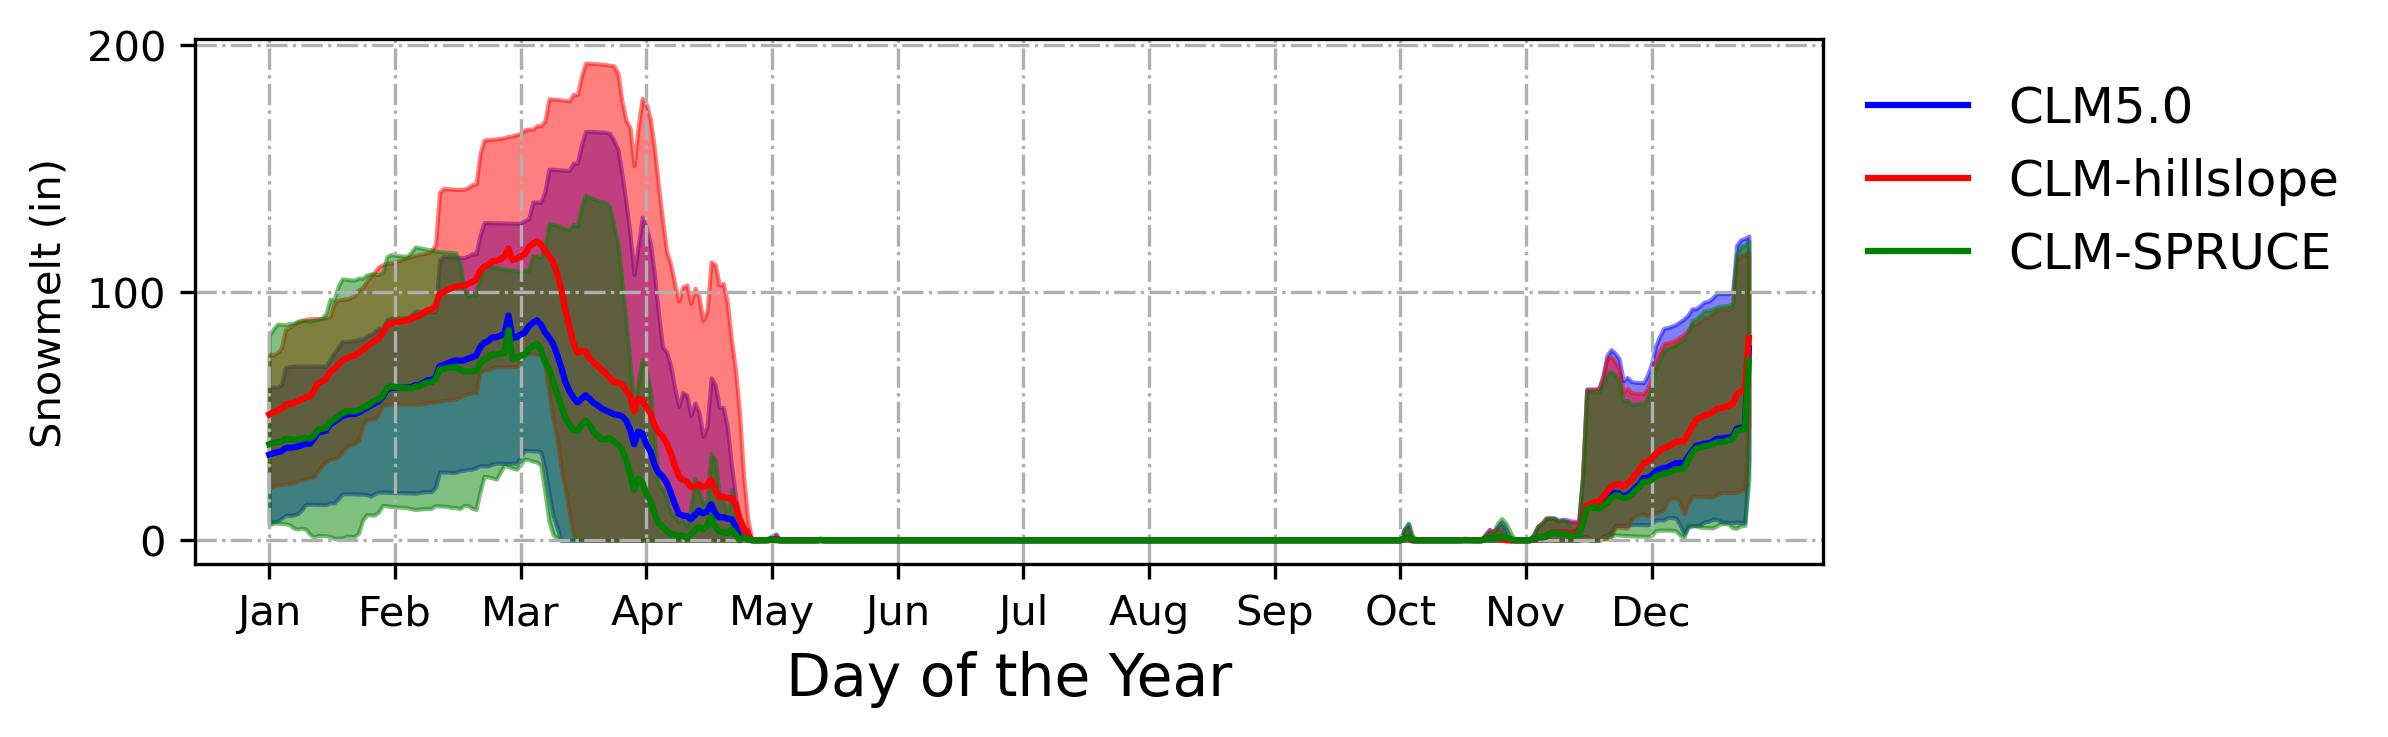

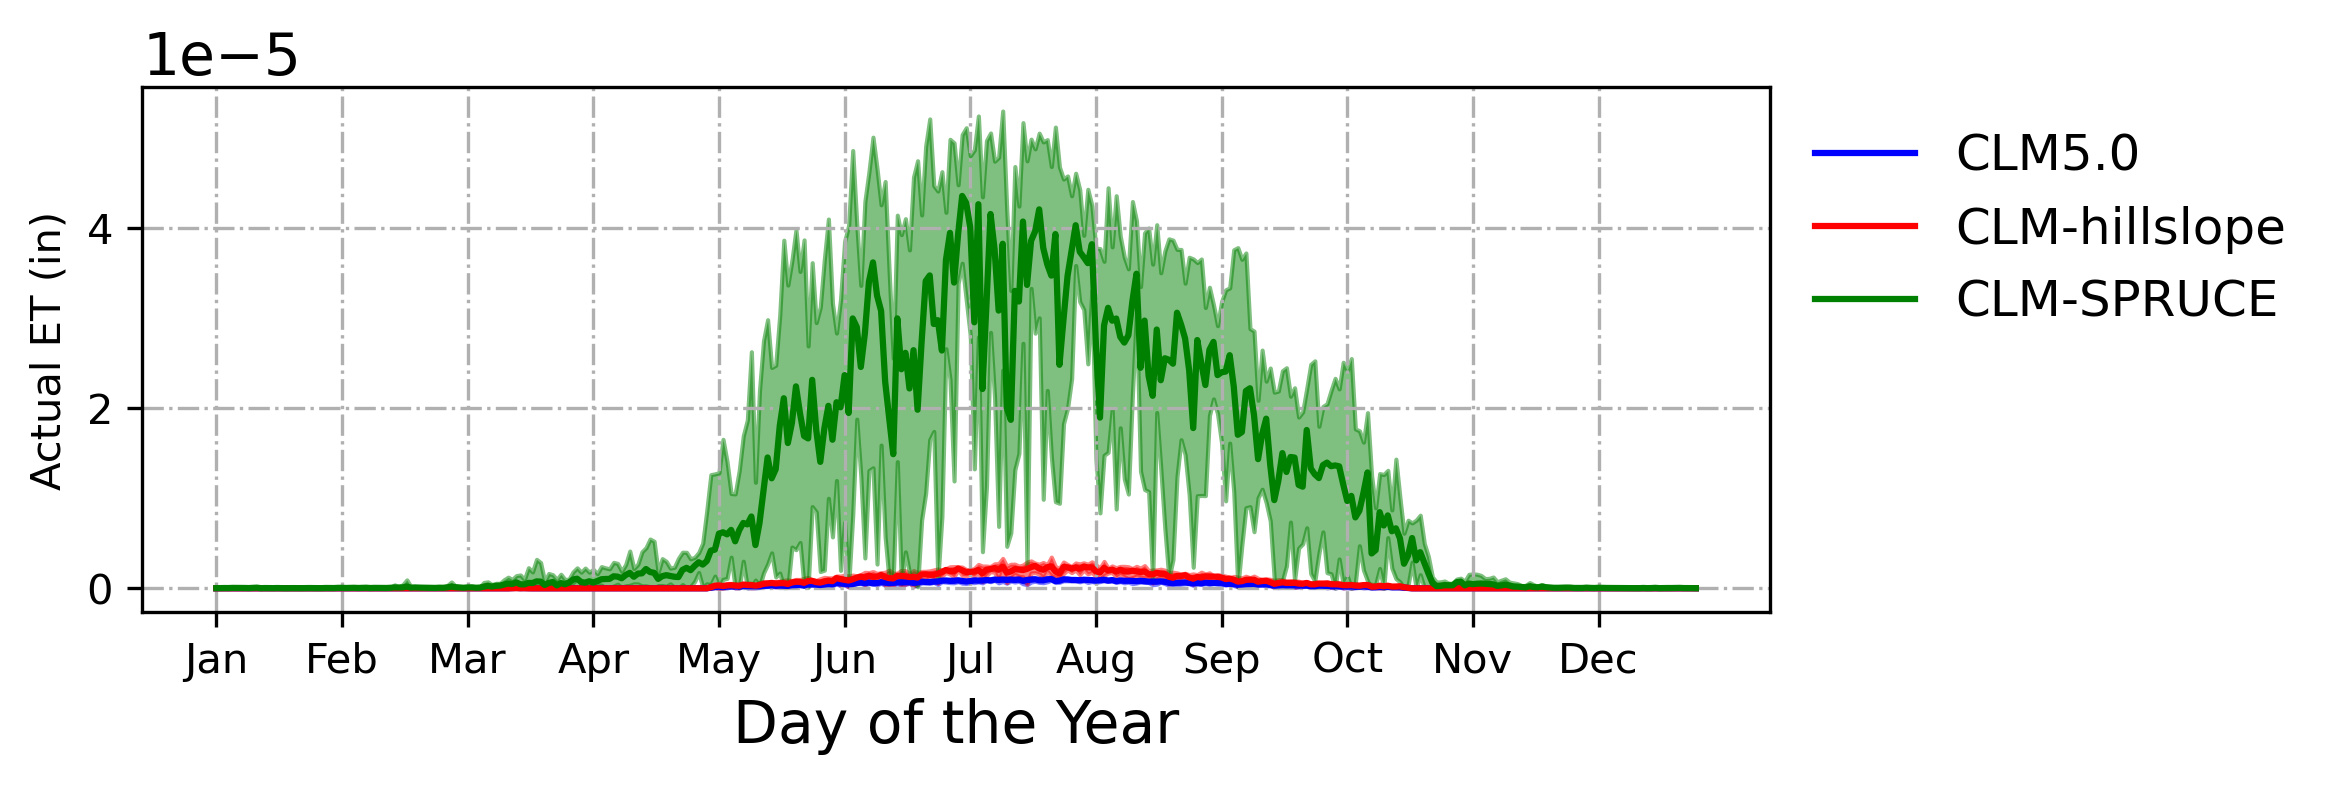

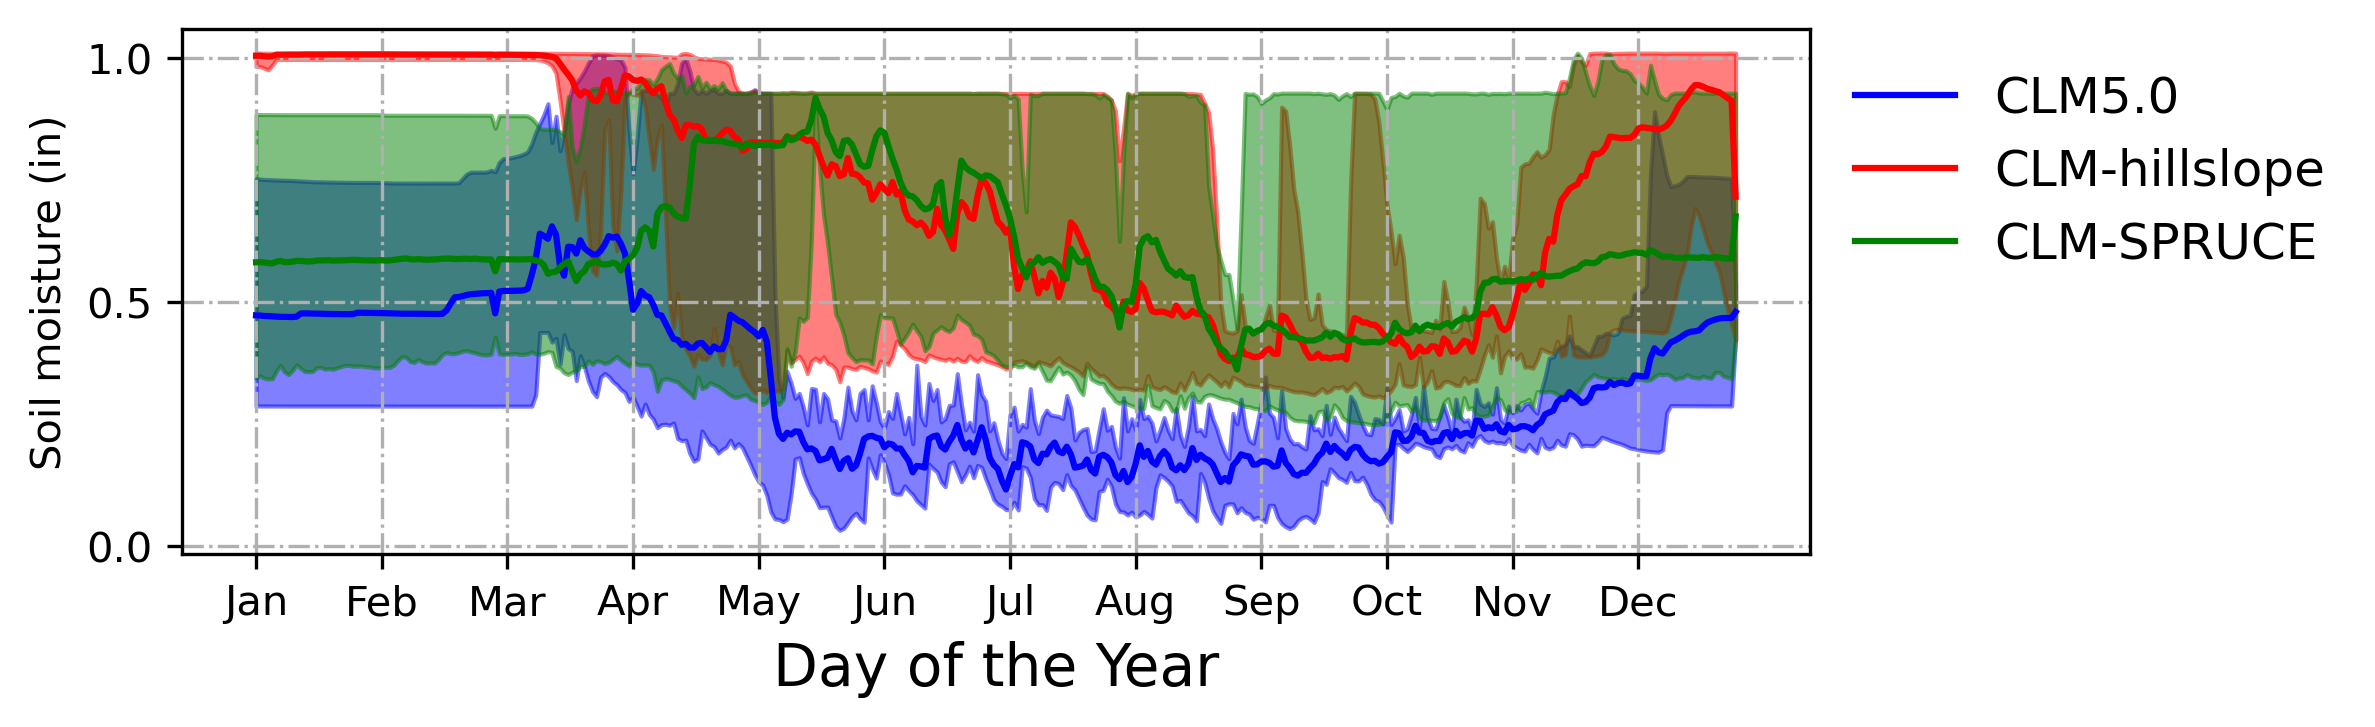

In [86]:
plotDoYBounds(PdUnCalib_clm, PdUnCalib_hillslope, PdUnCalib_spruce,
              'basin_snowmelt', 'Snowmelt (in)',
              'CLM5.0', 'CLM-hillslope', 'CLM-SPRUCE')
plt.savefig("./Result/Snowmelt.jpg", dpi=300,bbox_inches='tight')
plotDoYBounds(PdUnCalib_clm, PdUnCalib_hillslope, PdUnCalib_spruce, 
              'basin_actet', 'Actual ET (in)',
               'CLM5.0', 'CLM-hillslope', 'CLM-SPRUCE')
plt.savefig("./Result/ActuaET.jpg", dpi=300,bbox_inches='tight')
plotDoYBounds(PdUnCalib_clm, PdUnCalib_hillslope, PdUnCalib_spruce,
              'basin_soil_moist', 'Soil moisture (in)',
              'CLM5.0', 'CLM-hillslope', 'CLM-SPRUCE')
plt.savefig("./Result/SoilMoisture.jpg", dpi=300,bbox_inches='tight')

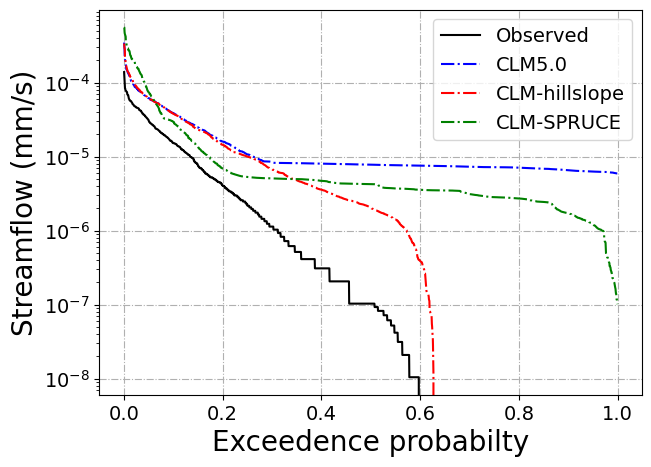

In [82]:
#Flow DurationCurve
SlopeInterval = [25,45]
plt.figure(figsize=[7,5]) #10,4
slope_Obs = plot_FDC(UnCalibMat_clm[:,0], SlopeInterval, 'Observed','k', ' (mm/s)') 
slope_UnCalib_clm = plot_FDC(UnCalibMat_clm[:,4],SlopeInterval, 'CLM5.0', 'b-.', ' (mm/s)'  )
slope_UnCalib_hillslope = plot_FDC(UnCalibMat_hillslope[:,4],SlopeInterval, 'CLM-hillslope', 'r-.', ' (mm/s)'  )
slope_UnCalib_SPRUCE = plot_FDC(UnCalibMat_spruce[:,4],SlopeInterval, 'CLM-SPRUCE', 'g-.', ' (mm/s)'  )
plt.savefig("./Result/FDC.jpg", dpi=300,bbox_inches='tight')

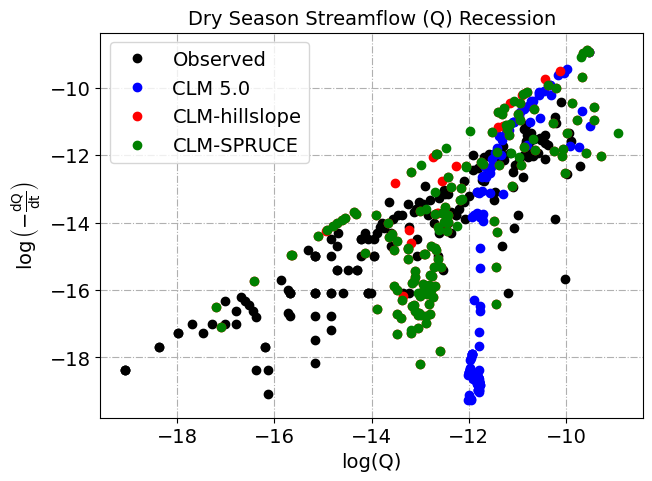

In [94]:
plt.figure(figsize=[7,5]) #10,4, #Wet, Dry, All
Season = 'Dry' 
ReceCoeff_Obs = plotRecession(PdUnCalib_clm.basin_ppt, PdUnCalib_clm.observed_Q, dateTimeD, 'Streamflow (Q) Recession','ko',
              'Observed',season = Season, alpha=1)
ReceCoeff_CLM = plotRecession(PdUnCalib_clm.basin_ppt, PdUnCalib_clm.model_Q, dateTimeD, 'Streamflow (Q) Recession','bo',
              'CLM 5.0',season = Season, alpha=1)
ReceCoeff_Hillslope = plotRecession(PdUnCalib_hillslope.basin_ppt, PdUnCalib_hillslope.model_Q, dateTimeD, 'Streamflow (Q) Recession','ro',
              'CLM-hillslope',season = Season, alpha=1)
ReceCoeff_Spruce = plotRecession(PdUnCalib_spruce.basin_ppt, PdUnCalib_hillslope.model_Q, dateTimeD, 'Streamflow (Q) Recession','go',
              'CLM-SPRUCE',season = Season, alpha=1)

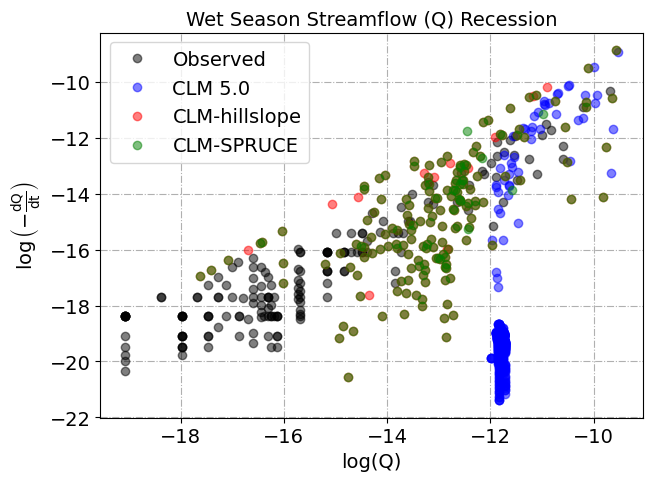

In [98]:
plt.figure(figsize=[7,5]) #10,4, #Wet, Dry, All
Season = 'Wet' 
ReceCoeff_Obs = plotRecession(PdUnCalib_clm.basin_ppt, PdUnCalib_clm.observed_Q, dateTimeD, 'Streamflow (Q) Recession','ko',
              'Observed',season = Season, alpha=0.5)
ReceCoeff_CLM = plotRecession(PdUnCalib_clm.basin_ppt, PdUnCalib_clm.model_Q, dateTimeD, 'Streamflow (Q) Recession','bo',
              'CLM 5.0',season = Season, alpha=0.5)
ReceCoeff_Hillslope = plotRecession(PdUnCalib_hillslope.basin_ppt, PdUnCalib_hillslope.model_Q, dateTimeD, 'Streamflow (Q) Recession','ro',
              'CLM-hillslope',season = Season, alpha=0.5)
ReceCoeff_Spruce = plotRecession(PdUnCalib_spruce.basin_ppt, PdUnCalib_hillslope.model_Q, dateTimeD, 'Streamflow (Q) Recession','go',
              'CLM-SPRUCE',season = Season, alpha=0.5)

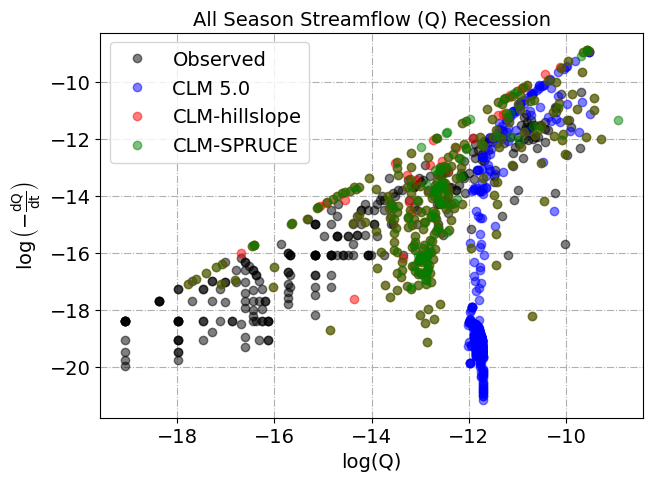

In [97]:
plt.figure(figsize=[7,5]) #10,4, #Wet, Dry, All
Season = 'All' 
ReceCoeff_Obs = plotRecession(PdUnCalib_clm.basin_ppt, PdUnCalib_clm.observed_Q, dateTimeD, 'Streamflow (Q) Recession','ko',
              'Observed',season = Season, alpha=0.5)
ReceCoeff_CLM = plotRecession(PdUnCalib_clm.basin_ppt, PdUnCalib_clm.model_Q, dateTimeD, 'Streamflow (Q) Recession','bo',
              'CLM 5.0',season = Season, alpha=0.5)
ReceCoeff_Hillslope = plotRecession(PdUnCalib_hillslope.basin_ppt, PdUnCalib_hillslope.model_Q, dateTimeD, 'Streamflow (Q) Recession','ro',
              'CLM-hillslope',season = Season, alpha=0.5)
ReceCoeff_Spruce = plotRecession(PdUnCalib_spruce.basin_ppt, PdUnCalib_hillslope.model_Q, dateTimeD, 'Streamflow (Q) Recession','go',
              'CLM-SPRUCE',season = Season, alpha=0.5)

In [115]:
tableCLM = pd.DataFrame(data = PdUnCalib_clm[['basin_ppt', 'observed_Q', 'model_Q']])
tableSPRUCE = pd.DataFrame(data = PdUnCalib_spruce[['basin_ppt', 'observed_Q', 'model_Q']])
tableHILLSLOPE = pd.DataFrame(data = PdUnCalib_hillslope[['basin_ppt', 'observed_Q', 'model_Q']])

In [120]:
def AnnualRunoffCoefficient(table,StrtHydroYear,EndHydroYear,PrecipName,RunoffName):
    
    """Returns annual runoff coefficient.
    
    .. ref::
    

    Parameters
    ----------
    table : numpy array containg precipitation, observed streamflow and model simulated streamflow.  
        
    StrtHydroYear : Starting month of the hydrological year. Default is October.
    EndHydroYear : Ending month of the hydrological year. Default is September.
    PrecipName : name of the precipitation data.
    RunoffName : name of the streamflow data.
    
    Returns
    -------
    Annual Runoff Coefficient for both observed and model data.

    """
    
    yearInt = min(table.index.year)
    yearMax = max(table.index.year)

    years = np.arange(yearInt,yearMax, 1)
    lenYear = np.count_nonzero(years)

    RCoeff = np.nan*np.ones([lenYear,2])

    for year in years: # years
        if StrtHydroYear == None:
            srt = str(year) + '-10-01'
        else:
            srt = str(year) + str(StrtHydroYear)
            
        if EndHydroYear ==None:
            end = str(year+1) + '-09-30'
        else:
            end = str(year+1) + EndHydroYear
            
        NewT = table.loc[pd.to_datetime(srt):pd.to_datetime(end),:]
        Pyr = np.sum(NewT[str(PrecipName)])
        Qyr = np.sum(NewT[str(RunoffName)])

        RC = Qyr/Pyr #AET = Pyr - Q
        RCoeff[year-yearInt,0] = year
        RCoeff[year-yearInt,1] = RC
        

    StationRCoeff = np.nanmean(RCoeff[:,1])
    
    return  RCoeff, StationRCoeff

In [121]:
# Compute annual and total runoff coefficients
Ann_CalR_obs, Tot_CalR_obs = AnnualRunoffCoefficient(tableCLM,None,None,'basin_ppt','observed_Q')
Ann_UnCalR_CLM, Tot_UnCalR_CLM = AnnualRunoffCoefficient(tableCLM,None,None,'basin_ppt','model_Q')
Ann_UnCalR_HILLSLOPE, Tot_UnCalR_HILLSLOPE = AnnualRunoffCoefficient(tableHILLSLOPE,None,None,'basin_ppt','model_Q')
Ann_UnCalR_SPRUCE, Tot_UnCalR_SPRUCE = AnnualRunoffCoefficient(tableSPRUCE,None,None,'basin_ppt','model_Q')

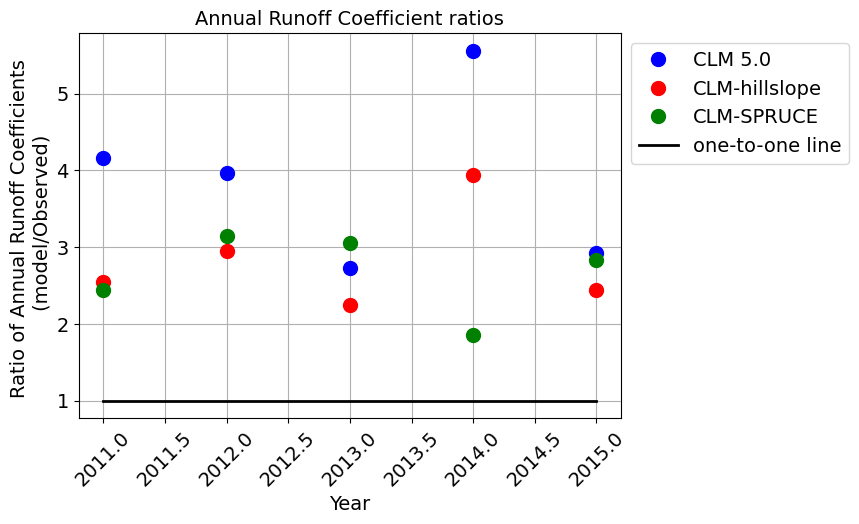

In [128]:
plt.figure(figsize=[7,5])
plt.plot(Ann_UnCalR_CLM[:,0], Ann_UnCalR_CLM[:,1]/Ann_CalR_obs[:,1],'bo',label ='CLM 5.0',markersize=10)
plt.plot(Ann_UnCalR_HILLSLOPE[:,0], Ann_UnCalR_HILLSLOPE[:,1]/Ann_CalR_obs[:,1],'ro',label ='CLM-hillslope',markersize=10)
plt.plot(Ann_UnCalR_SPRUCE[:,0], Ann_UnCalR_SPRUCE[:,1]/Ann_CalR_obs[:,1],'go',label ='CLM-SPRUCE',markersize=10)

plt.plot((np.min(Ann_CalR_obs[:,0]), np.max(Ann_CalR_obs[:,0])), 
         (1, 1),  linewidth=2, color='k', label='one-to-one line')
plt.xlabel('Year',fontsize=14)
plt.ylabel('Ratio of Annual Runoff Coefficients \n (model/Observed)',fontsize=14)
plt.title('Annual Runoff Coefficient ratios',fontsize=14)
plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1), fontsize=14)
plt.xticks(rotation = 45)
plt.grid()
#print(' Calibrated Runoff Coeffcient Ratio (modR/ObsR) =', np.round(Tot_CalR_Mod/Tot_CalR_obs,3),'\n',
#      'Uncalibrated Runoff Coeffcient Ratio (modR/ObsR) = ', np.round(Tot_UnCalR_Mod/Tot_UnCalR_obs,3))
plt.savefig("./Result/RunoffCoefficient.jpg", dpi=300, bbox_inches='tight')